In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T
from synth import Synth, Wave
from synth_generator import WaveIterableDataset

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
	torch.set_default_tensor_type(torch.cuda.FloatTensor)
print(f"Using device: {device}")

Using device: cuda


c:\Users\leifm\OneDrive\Documents\Repos\SynthMaker\.venv\Lib\site-packages\torch\__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


In [2]:
dataset = WaveIterableDataset(duration=2.0, sample_rate=48000)
import multiprocessing
dataloader = DataLoader(
	dataset,
	batch_size=1000,
	#num_workers=multiprocessing.cpu_count() // 2,
	#multiprocessing_context=multiprocessing.get_context('spawn')
)

from parameter_predictor import SynthParameterPredictor, AudioFeatureExtractor

feature_extractor = AudioFeatureExtractor().to(device)
model = SynthParameterPredictor().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = 'synth_parameter_predictor.pth'
import os
if os.path.exists(checkpoint_path):
	checkpoint = torch.load(checkpoint_path)
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
	model.eval()
	print("Checkpoint loaded. Skipping training.")
	loadedModel = True
else:
	print("Checkpoint not found. Proceeding with training.")
	loadedModel = False

Checkpoint not found. Proceeding with training.


c:\Users\leifm\OneDrive\Documents\Repos\SynthMaker\synth_generator.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio, dtype=torch.float32)


Batch 1/500, Loss: 0.645830
Batch 2/500, Loss: 32.324535
Batch 3/500, Loss: 1.025454
Batch 4/500, Loss: 1.397468
Batch 5/500, Loss: 1.302151
Batch 6/500, Loss: 0.941629
Batch 7/500, Loss: 0.652036
Batch 8/500, Loss: 0.489584
Batch 9/500, Loss: 0.395405
Batch 10/500, Loss: 0.349786
Batch 11/500, Loss: 0.306140
Batch 12/500, Loss: 0.270391
Batch 13/500, Loss: 0.253256
Batch 14/500, Loss: 0.249143
Batch 15/500, Loss: 0.235454
Batch 16/500, Loss: 0.228322
Batch 17/500, Loss: 0.222937
Batch 18/500, Loss: 0.199262
Batch 19/500, Loss: 0.191113
Batch 20/500, Loss: 0.192575
Batch 21/500, Loss: 0.180294
Batch 22/500, Loss: 0.183949
Batch 23/500, Loss: 0.184261
Batch 24/500, Loss: 0.176446
Batch 25/500, Loss: 0.178820
Batch 26/500, Loss: 0.168614
Batch 27/500, Loss: 0.166808
Batch 28/500, Loss: 0.159235
Batch 29/500, Loss: 0.165730
Batch 30/500, Loss: 0.169325
Batch 31/500, Loss: 0.165038
Batch 32/500, Loss: 0.149367
Batch 33/500, Loss: 0.153061
Batch 34/500, Loss: 0.146446
Batch 35/500, Loss: 0.

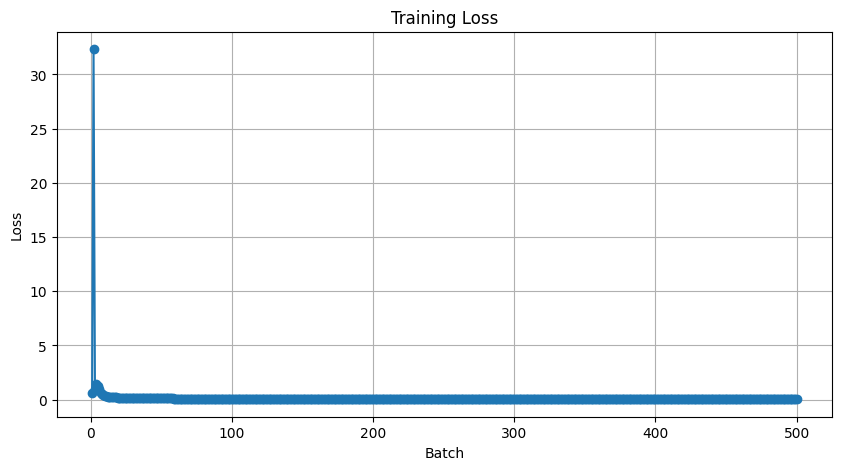

Model saved to 'synth_parameter_predictor.pth'


In [3]:
num_batches = 500
total_loss = 0
batch_losses = []

from parameter_predictor import normalize_batch, denormalize_batch

if not loadedModel:
	model.train()
	for batch_idx in range(0, num_batches):
		audio_batch, params_batch = next(iter(dataloader))
				
		audio_batch = audio_batch.to(device)
		params_batch = params_batch.to(device)
		
		normalized_params = normalize_batch(params_batch, dataset.param_ranges).to(device)
		
		with torch.no_grad():
			features = feature_extractor(audio_batch)
		
		optimizer.zero_grad()
		predictions = model(features.unsqueeze(1))
		loss = criterion(predictions, normalized_params)
		
		loss.backward()
		optimizer.step()
		
		batch_loss = loss.item()
		batch_losses.append(batch_loss)
		
		print(f"Batch {batch_idx+1}/{num_batches}, Loss: {batch_loss:.6f}")
		
		if batch_idx == num_batches - 1:  #Last batch
			model.eval()

			with torch.no_grad():
				sample_indices = torch.randint(0, len(audio_batch), (5,))
				sample_audio = audio_batch[sample_indices]
				sample_params = params_batch[sample_indices]
				
				sample_features = feature_extractor(sample_audio).unsqueeze(1)
				sample_predictions = model(sample_features)

				print("Shape of audio:", sample_audio.shape)
				print("Shape of features:", sample_features.shape)
				
				denorm_predictions = denormalize_batch(sample_predictions, dataset.param_ranges).detach().cpu().numpy()
				
				print("\nSample Predictions:")
				print("Index | Parameter | True Value | Predicted Value")
				print("-" * 50)
				
				param_names = ['Frequency', 'Phase', 'Volume']
				for i, (true, pred) in enumerate(zip(sample_params, denorm_predictions)):
					print(f"Sample {i+1}:")
					for j, name in enumerate(param_names):
						print(f"  {name}: {true[j]:.4f} | {pred[j]:.4f}")


	plt.figure(figsize=(10, 5))
	plt.plot(range(1, num_batches+1), batch_losses, marker='o')
	plt.title('Training Loss')
	plt.xlabel('Batch')
	plt.ylabel('Loss')
	plt.grid(True)
	plt.show()

	torch.save({
		'model_state_dict': model.state_dict(),
		'optimizer_state_dict': optimizer.state_dict(),
	}, 'synth_parameter_predictor.pth')
	print("Model saved to 'synth_parameter_predictor.pth'")

In [4]:
from parameter_adjustment import SynthParameterAdjuster, train_with_adjustment, predict_with_adjustment

class FullSynthPredictor(nn.Module):
	def __init__(self, feature_extractor, parameter_predictor):
		super(FullSynthPredictor, self).__init__()
		self.feature_extractor = feature_extractor
		self.parameter_predictor = parameter_predictor
		
	def forward(self, audio):
		features = self.feature_extractor(audio).unsqueeze(1)
		return self.parameter_predictor(features)

full_model = FullSynthPredictor(feature_extractor, model).to(device)
if model:
	del model

adjuster = SynthParameterAdjuster().to(device)
adj_optimizer = optim.Adam(adjuster.parameters(), lr=0.001)
adj_criterion = nn.MSELoss()

adjustor_checkpoint_path = 'synth_parameter_adjuster.pth'
if os.path.exists(adjustor_checkpoint_path):
	checkpoint = torch.load(adjustor_checkpoint_path)
	adjuster.load_state_dict(checkpoint['model_state_dict'])
	print("Parameter adjuster model loaded from checkpoint.")
else:
	print("Training parameter adjuster model...")
	adjuster = train_with_adjustment(
		base_model=full_model,
		adjustment_model=adjuster,
		dataset=dataset,
		device=device,
		num_epochs=500
	)
	
	torch.save({
		'model_state_dict': adjuster.state_dict(),
	}, adjustor_checkpoint_path)
	print(f"Parameter adjuster model saved to {adjustor_checkpoint_path}")


print("Testing prediction with parameter adjustment...")
with torch.no_grad():
	test_audio, test_params = next(iter(dataset))
	test_audio = test_audio.to(device)
	test_params = test_params.to(device)
	
	predictions_with_adj, base_params = predict_with_adjustment(
		audio=test_audio,
		base_model=full_model,
		adjustment_model=adjuster,
		device=device,
	)
	
	param_names = ['Frequency', 'Phase', 'Volume']
	print("\nPrediction Results:")
	print("Parameter | True Value | Without Adj | With Adj")
	print("-" * 65)
	
	for j, name in enumerate(param_names):
		print(f"  {name}: {test_params[j]} | {base_params[j]} | {predictions_with_adj[j]}")

Training parameter adjuster model...


c:\Users\leifm\OneDrive\Documents\Repos\SynthMaker\synth.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.phase = torch.tensor(self.phase, requires_grad=True)
c:\Users\leifm\OneDrive\Documents\Repos\SynthMaker\synth.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.frequency = torch.tensor(self.frequency, requires_grad=True)
c:\Users\leifm\OneDrive\Documents\Repos\SynthMaker\synth.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.volume = torch.tensor(self.volume, requires_grad=True)


Epoch 1, Loss: 63373.1211
Epoch 2, Loss: 67868.6641
Epoch 3, Loss: 71685.3047
Epoch 4, Loss: 77508.2656
Epoch 5, Loss: 77455.3594
Epoch 6, Loss: 78567.2578
Epoch 7, Loss: 66711.4297
Epoch 8, Loss: 60646.2422
Epoch 9, Loss: 66515.3516
Epoch 10, Loss: 69764.2266
Epoch 11, Loss: 52327.3203
Epoch 12, Loss: 47988.1992
Epoch 13, Loss: 50758.2734
Epoch 14, Loss: 41757.1602
Epoch 15, Loss: 48110.7461
Epoch 16, Loss: 46142.1016
Epoch 17, Loss: 60513.1602
Epoch 18, Loss: 58410.2227
Epoch 19, Loss: 56570.2422
Epoch 20, Loss: 22997.5781
Epoch 21, Loss: 21409.8594
Epoch 22, Loss: 29042.4883
Epoch 23, Loss: 22538.0703
Epoch 24, Loss: 19041.8379
Epoch 25, Loss: 19148.8047
Epoch 26, Loss: 20767.6465
Epoch 27, Loss: 25480.7109
Epoch 28, Loss: 21401.5312
Epoch 29, Loss: 19540.6523
Epoch 30, Loss: 19882.8164
Epoch 31, Loss: 14429.0068
Epoch 32, Loss: 20239.5664
Epoch 33, Loss: 19219.8340
Epoch 34, Loss: 16884.0879
Epoch 35, Loss: 21992.7129
Epoch 36, Loss: 14444.9922
Epoch 37, Loss: 20084.0176
Epoch 38, 

Generating evaluation dataset...
Evaluating models...
Evaluating Baseline (440Hz, 0, 1)...
Evaluating Baseline (440Hz, 0.5, 0.5)...
Evaluating Random Predictor...
Evaluating Parameter Predictor...
Evaluating Predictor with Adjustment...


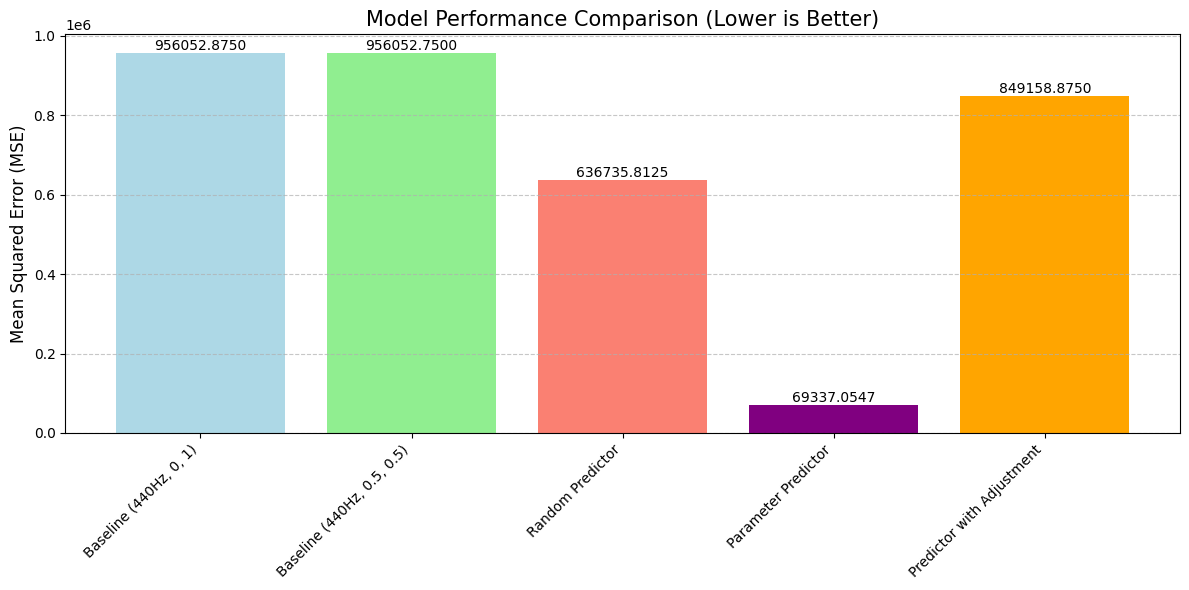


Parameter-wise MSE:
Parameter Predictor - Frequency MSE: 208011.062500
Parameter Predictor - Phase MSE: 0.103871
Parameter Predictor - Volume MSE: 0.018713
Predictor with Adjustment - Frequency MSE: 2547468.750000
Predictor with Adjustment - Phase MSE: 4.991370
Predictor with Adjustment - Volume MSE: 3.190711


In [5]:
class ConstantPredictor:
	def __init__(self, freq, phase, volume):
		self.params = torch.tensor([freq, phase, volume])
	
	def predict(self, _):
		return self.params.clone()

class RandomPredictor:
	def __init__(self, param_ranges):
		self.param_ranges = param_ranges
	
	def predict(self, _):
		random_params = torch.zeros(3)
		for thing in enumerate(self.param_ranges):
			i, param = thing
			(min_val, max_val) = self.param_ranges[param]
			random_params[i] = min_val + torch.rand(1).item() * (max_val - min_val)
		return random_params


baseline1 = ConstantPredictor(440.0, 0.0, 1.0)
baseline2 = ConstantPredictor(440.0, 0.5, 0.5)
random_model = RandomPredictor(dataset.param_ranges)

print("Generating evaluation dataset...")
num_samples = 1000
eval_dataloader = DataLoader(
	dataset,
	batch_size=num_samples
)
eval_audio, eval_params = next(iter(eval_dataloader))
eval_audio = eval_audio.to(device)
eval_params = eval_params.to(device)

print("Evaluating models...")
models = {
	"Baseline (440Hz, 0, 1)": baseline1,
	"Baseline (440Hz, 0.5, 0.5)": baseline2,
	"Random Predictor": random_model,
	"Parameter Predictor": None,
	"Predictor with Adjustment": None
}
results = {}

for name, model_instance in models.items():
	if model_instance is not None:
		print(f"Evaluating {name}...")
		predictions = torch.stack([model_instance.predict(None) for _ in range(num_samples)])
		mse = nn.MSELoss()(predictions.to(device), eval_params).item()
		results[name] = mse

print("Evaluating Parameter Predictor...")
with torch.no_grad():
	full_model.eval()
	features = full_model.feature_extractor(eval_audio)
	normalized_preds = full_model.parameter_predictor(features.unsqueeze(1))
	denormalized_preds = denormalize_batch(normalized_preds, dataset.param_ranges)
	mse = nn.MSELoss()(denormalized_preds, eval_params).item()
	results["Parameter Predictor"] = mse

print("Evaluating Predictor with Adjustment...")
with torch.no_grad():
	full_model.eval()
	adjuster.eval()
	all_adjusted_preds = []

	for i in range(num_samples):
		sample_audio = eval_audio[i:i+1]
		adjusted_params, _ = predict_with_adjustment(
			audio=sample_audio.squeeze(0),
			base_model=full_model,
			adjustment_model=adjuster,
			device=device
		)
		all_adjusted_preds.append(adjusted_params)
	
	all_adjusted_preds = torch.stack(all_adjusted_preds)
	mse = nn.MSELoss()(all_adjusted_preds, eval_params).item()
	results["Predictor with Adjustment"] = mse

plt.figure(figsize=(12, 6))
names = list(results.keys())
mse_values = list(results.values())
bars = plt.bar(names, mse_values, color=['lightblue', 'lightgreen', 'salmon', 'purple', 'orange'])
plt.title('Model Performance Comparison (Lower is Better)', fontsize=15)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
	height = bar.get_height()
	plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
			 f'{height:.4f}',
			 ha='center', va='bottom', fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

print("\nParameter-wise MSE:")
param_names = ['Frequency', 'Phase', 'Volume']

with torch.no_grad():
	full_model.eval()
	features = full_model.feature_extractor(eval_audio)
	normalized_preds = full_model.parameter_predictor(features.unsqueeze(1))
	denormalized_preds = denormalize_batch(normalized_preds, dataset.param_ranges)
	
	for i, param in enumerate(param_names):
		param_mse = nn.MSELoss()(denormalized_preds[:, i], eval_params[:, i]).item()
		print(f"Parameter Predictor - {param} MSE: {param_mse:.6f}")

with torch.no_grad():
	for i, param in enumerate(param_names):
		param_mse = nn.MSELoss()(all_adjusted_preds[:, i], eval_params[:, i]).item()
		print(f"Predictor with Adjustment - {param} MSE: {param_mse:.6f}")